In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pygam import LogisticGAM, s, f
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_excel('../data/Задание (пролонгация).xlsx', sheet_name='data_full')

# Features and Target

In [3]:
del df['ID']  # ID is not needed

In [4]:
# Make target binary
df['target'] = df['target'].apply(lambda x: x if x == -1 else 0)

In [5]:
X = df.drop('target', axis=1)
y = df['target']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

In [13]:
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

In [17]:
categorical_cols

Index(['Filial', 'Type_ts', 'passport_region', 'VIP', 'Brand', 'Model', 'GAP',
       'married', 'deduct', 'deduct_amount', 'product', 'Bank',
       'channel - map', 'category', 'kvs_type', 'sex'],
      dtype='object')

In [18]:
numerical_cols

Index(['Yr_production', 'KBM', 'KBM_prol_est', 'delta_kbm', 'Age', 'Exp',
       'discount', 'Amount - gr', 'premium_car', 'price_gr', 'price_prc',
       'OSAGO_clnt'],
      dtype='object')

## Scaling and Encoding

In [16]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Model

## Log Reg

In [18]:
model = LogisticRegression(max_iter=1000)

In [19]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

### Fit

In [20]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Yr_production', 'KBM', 'KBM_prol_est', 'delta_kbm', 'Age', 'Exp',
       'discount', 'Amount - gr', 'premium_car', 'price_gr', 'price_prc',
       'OSAGO_clnt'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Filial', 'Type_ts', 'passport_region', 'VIP', 'Brand', 'Model', 'GAP',
       'married', 'deduct', 'deduct_amount', 'product', 'Bank',
       'channel - map', 'category', 'kvs_type', 'sex'],
      dtype='object'))])),
                ('model', LogisticRegression(max_iter=1000))])

### Predict

In [21]:
y_pred = pipeline.predict(X_test)

### Evaluation

In [22]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

          -1       0.33      0.01      0.02       656
           0       0.70      0.99      0.82      1517

    accuracy                           0.69      2173
   macro avg       0.52      0.50      0.42      2173
weighted avg       0.59      0.69      0.58      2173

Confusion Matrix:
 [[   7  649]
 [  14 1503]]


### Test Visualization

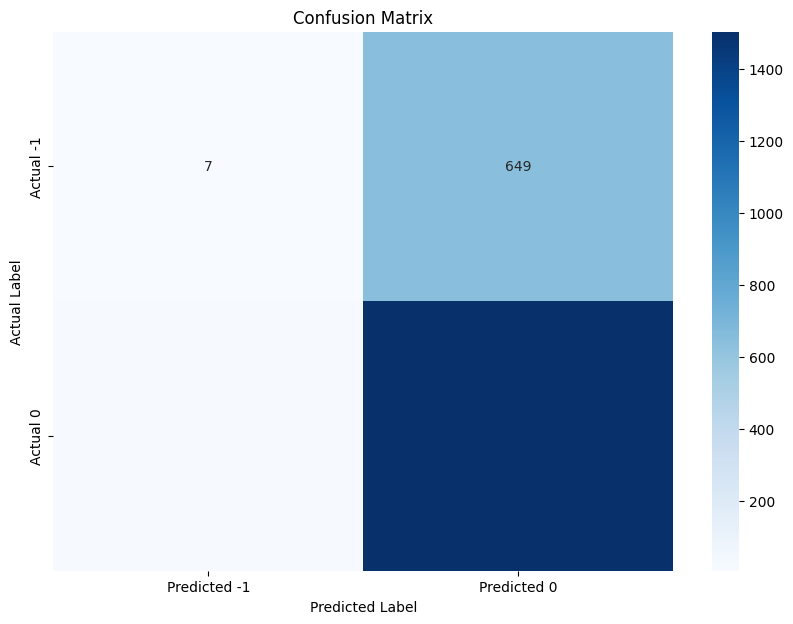

In [26]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted -1', 'Predicted 0'], yticklabels=['Actual -1', 'Actual 0'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

### Feature Importance

In [32]:
onehot_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat']

In [34]:
categorical_features_encoded = onehot_encoder.get_feature_names_out(categorical_cols)

In [37]:
features = np.concatenate([numerical_cols, categorical_features_encoded])

In [39]:
coefs = model.coef_[0]

In [43]:
feature_importance = pd.DataFrame(coefs, index=features, columns=['Importance'])
feature_importance['Abs_Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Importance', ascending=False)

In [44]:
feature_importance

,Importance,Abs_Importance
Model_GRAND SANTA FE,-1.268441,1.268441
Model_3,-1.113932,1.113932
passport_region_Томская область,1.072932,1.072932
passport_region_Алтайский край,-0.918373,0.918373
passport_region_н.д.,0.878671,0.878671
...,...,...
Brand_MAZDA,0.002508,0.002508
price_prc,-0.002435,0.002435
deduct_Безусловная франшиза,-0.002171,0.002171
passport_region_Смоленская область,0.001041,0.001041


In [46]:
model_classes = model.classes_

In [47]:
model_classes

array([-1,  0])

There are lots of unnecessary features

In [30]:
coefs  # here columns are busted, need to fix that

array([-2.45969653e-02,  2.71104192e-01, -2.44100648e-01, -1.46939400e-02,
        3.67659656e-02, -5.36338829e-02,  2.70059375e-02,  6.83321213e-02,
        3.55243825e-03, -6.62511654e-02, -2.43509932e-03, -1.36571583e-02,
       -4.14554551e-02, -6.86189599e-02,  1.77338769e-01, -2.28449077e-01,
       -2.23844641e-01,  6.82578751e-01,  8.97720244e-02, -2.35084604e-01,
       -9.79661737e-02,  2.13045983e-01,  1.81492001e-02,  5.23552662e-02,
       -4.13432801e-01,  4.45805203e-01, -1.28076163e-01,  5.16110594e-02,
       -1.57807687e-01, -1.28742376e-01,  2.66255340e-01, -1.24156515e-01,
       -7.64026465e-02,  3.09398722e-02, -1.36548394e-02,  1.17469207e-01,
       -9.18373030e-01, -3.29554596e-01,  7.46662529e-01,  3.72395736e-01,
       -1.38137027e-01,  2.81563114e-01, -1.80574708e-01, -1.37901354e-01,
        8.72976740e-02, -2.17007149e-01, -2.69227427e-01,  4.08245342e-01,
        2.54616616e-01, -1.51889977e-01,  1.78726771e-01, -1.86844406e-02,
        1.92797994e-02, -

In [76]:
feature_importance.reset_index(inplace=True)

In [78]:
feature_importance.to_csv('feature_importance_log_reg.csv', sep=';', index=False)

### Explanation

The model is highly effective at identifying class 0 instances, as evidenced by a recall of 0.99 and a high number of true positives (1503).
However, it struggles significantly with class -1, with a very low recall (0.01), indicating it hardly identifies any true class -1 instances correctly, and a precision of 0.33, which is also quite low.
The very high false positive rate for class -1 (649 out of 656) indicates that the model almost always incorrectly predicts class -1 instances as class 0.
The overall accuracy of 0.69 might seem decent, but the model's effectiveness is heavily skewed towards class 0, making it unreliable for classifying instances of class -1.

## Decision Tree

In [49]:
model = DecisionTreeClassifier(random_state=42)

In [50]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

### Fit

In [51]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Yr_production', 'KBM', 'KBM_prol_est', 'delta_kbm', 'Age', 'Exp',
       'discount', 'Amount - gr', 'premium_car', 'price_gr', 'price_prc',
       'OSAGO_clnt'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Filial', 'Type_ts', 'passport_region', 'VIP', 'Brand', 'Model', 'GAP',
       'married', 'deduct', 'deduct_amount', 'product', 'Bank',
       'channel - map', 'category', 'kvs_type', 'sex'],
      dtype='object'))])),
                ('model', DecisionTreeClassifier(random_state=42))])

### Predict and Evaluate

In [52]:
y_pred = pipeline.predict(X_test)

In [53]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

          -1       0.29      0.31      0.30       656
           0       0.69      0.68      0.69      1517

    accuracy                           0.57      2173
   macro avg       0.49      0.49      0.49      2173
weighted avg       0.57      0.57      0.57      2173

Confusion Matrix:
 [[ 201  455]
 [ 488 1029]]


Results no better than with Log Reg

### Feature Importance

In [32]:
onehot_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat']

In [34]:
categorical_features_encoded = onehot_encoder.get_feature_names_out(categorical_cols)

In [37]:
features = np.concatenate([numerical_cols, categorical_features_encoded])

In [39]:
coefs = model.coef_[0]

In [55]:
feature_importance_tree = pd.DataFrame(coefs, index=features, columns=['Importance'])
feature_importance_tree['Abs_Importance'] = feature_importance_tree['Importance'].abs()
feature_importance_tree = feature_importance_tree.sort_values(by='Abs_Importance', ascending=False)

In [56]:
feature_importance_tree

,Importance,Abs_Importance
Model_GRAND SANTA FE,-1.268441,1.268441
Model_3,-1.113932,1.113932
passport_region_Томская область,1.072932,1.072932
passport_region_Алтайский край,-0.918373,0.918373
passport_region_н.д.,0.878671,0.878671
...,...,...
Brand_MAZDA,0.002508,0.002508
price_prc,-0.002435,0.002435
deduct_Безусловная франшиза,-0.002171,0.002171
passport_region_Смоленская область,0.001041,0.001041


In [79]:
feature_importance_tree.reset_index().to_csv('feature_importance_tree.csv', sep=';', index=False)

Feature Importance also similar to Log Reg

## GAM

### Scaling and Encoding

In [59]:
# Make target binary, force it to 1 or 0
df['target'] = df['target'].apply(lambda x: abs(x) if x == -1 else 0)

In [60]:
X = df.drop('target', axis=1)
y = df['target']

In [62]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

In [63]:
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

In [64]:
categorical_cols

Index(['Filial', 'Type_ts', 'passport_region', 'VIP', 'Brand', 'Model', 'GAP',
       'married', 'deduct', 'deduct_amount', 'product', 'Bank',
       'channel - map', 'category', 'kvs_type', 'sex'],
      dtype='object')

In [65]:
numerical_cols

Index(['Yr_production', 'KBM', 'KBM_prol_est', 'delta_kbm', 'Age', 'Exp',
       'discount', 'Amount - gr', 'premium_car', 'price_gr', 'price_prc',
       'OSAGO_clnt'],
      dtype='object')

In [67]:
scaler = StandardScaler()
X_numerical_scaled = pd.DataFrame(scaler.fit_transform(X[numerical_cols]),
                                  columns=numerical_cols)
X_categorical_encoded = pd.get_dummies(X[categorical_cols])
X_preprocessed = pd.concat([X_numerical_scaled, X_categorical_encoded], axis=1)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

### Fit

In [72]:
gam = LogisticGAM().fit(X_train, y_train)  # 9:25

LinAlgError: SVD did not converge

In [73]:
# Too many features, need to carefully select